In [3]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import pytz
import matplotlib.pyplot as plt
import os
import glob
import plotly.express as px
from scipy.interpolate import griddata

In [4]:
skip = np.arange(0, 11).tolist() + np.arange(12, 15).tolist()

In [5]:
## also skip 13 and 14
mat_code = pd.read_csv('SZA_Cloudy_Chl0p5_fixed.txt', delimiter = '  ', skiprows = skip)
mat_code

/var/folders/rl/0vwydsgj6nx5gmddmc5qtxz00000gn/T/ipykernel_547/250458132.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  mat_code = pd.read_csv('SZA_Cloudy_Chl0p5_fixed.txt', delimiter = '  ', skiprows = skip)


,thetasun,Ed(air),Eu(air),PAR_Ed(air),PAR_Eo(air),Ed(z=0),Eu(z=0),PAR_Ed(z=0),PAR_Eo(z=0)
0,0.0,116.94000,7.040100,535.3500,1048.3000,112.00000,2.095500,512.0200,626.8500
1,2.0,116.86000,7.043600,534.9800,1048.6000,111.91000,2.094300,511.6300,626.4600
2,4.0,116.62000,7.038400,533.8600,1047.6000,111.67000,2.090100,510.5100,625.2100
3,6.0,116.21000,7.024700,531.9900,1045.3000,111.26000,2.083000,508.6800,623.1100
4,8.0,115.63000,7.002300,529.3800,1041.8000,110.70000,2.073000,506.1200,620.1600
...,...,...,...,...,...,...,...,...,...
229,82.0,8.69280,0.499680,39.7190,83.0700,8.36410,0.170970,38.1570,49.4250
230,84.0,5.89570,0.341090,26.7210,55.9440,5.67580,0.121240,25.6830,33.3480
231,86.0,3.58860,0.209480,16.0680,33.6720,3.45760,0.078444,15.4560,20.1410
232,88.0,1.69650,0.099837,7.5046,15.7340,1.63580,0.039141,7.2245,9.4488


In [6]:
g4_data = pd.read_csv('g4_merged_data')
g4_data['sun_zen_angle'].max()
# anythign over 90 degrees, subtract it by 90
g4_data['new_sun_zen'] = 0
angle = np.where(g4_data['sun_zen_angle'] > 90, 180 - g4_data['sun_zen_angle'], g4_data['sun_zen_angle'])
g4_data['new_sun_zen'] = angle
g4_data.loc[g4_data['sun_zen_angle'] > 90]
g4_data.drop(['Unnamed: 0'], axis = 1, inplace = True)
g4_data

,time,licor_par,cruise,pop,n_per_uL,c_per_uL,lat,lon,temp,salinity,par,diam_med,hour,round_lat,round_lon,scalar,chla_eco,sat_par,sun_zen_angle,new_sun_zen
0,2021-11-19 17:00:00+00:00,486.087167,TN397_740,prochloro,59.103647,1.471909,31.047502,-119.963323,17.614825,33.200625,909.702550,0.024904,17,31.0,-120.0,5.205841,0.234573,576.539448,64.306618,64.306618
1,2021-11-19 18:00:00+00:00,891.885167,TN397_740,prochloro,73.904420,1.901776,30.962975,-120.109363,17.633781,33.158950,1619.012500,0.025733,18,31.0,-120.0,5.037268,0.163371,1088.754558,56.584970,56.584970
2,2021-11-19 19:00:00+00:00,1092.274333,TN397_740,prochloro,60.774550,1.420525,30.799496,-120.382978,18.038000,33.079418,1876.892611,0.023374,19,31.0,-120.5,5.219913,0.107802,1286.427594,51.885782,51.885782
3,2021-11-19 20:00:00+00:00,1002.763667,TN397_740,prochloro,55.664875,1.528290,30.685723,-120.577657,17.635111,33.002106,1953.495900,0.027455,20,30.5,-120.5,5.233759,0.146960,1217.701810,50.218605,50.218605
4,2021-11-19 21:00:00+00:00,922.692167,TN397_740,prochloro,63.412060,1.730710,30.605379,-120.714316,17.676354,33.059641,2278.979714,0.027293,21,30.5,-120.5,5.602349,0.139737,1091.592987,53.078498,53.078498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,2021-12-13 18:00:00+00:00,688.223000,TN397_740,prochloro,241.180751,8.157731,14.772220,-152.864218,26.781531,33.951840,1866.283750,0.033824,18,15.0,-153.0,9.271543,0.077962,1210.487611,71.270990,71.270990
469,2021-12-13 19:00:00+00:00,1092.185333,TN397_740,prochloro,245.492471,8.885463,14.777021,-152.867004,26.787131,33.953178,2020.028100,0.036194,19,15.0,-153.0,9.141849,0.068782,1266.557619,59.442556,59.442556
470,2021-12-13 20:00:00+00:00,1320.478000,TN397_740,prochloro,244.086001,9.166140,14.812232,-152.894542,26.764932,33.947510,2178.220650,0.037553,20,15.0,-153.0,9.028236,0.050990,1365.744348,49.127855,49.127855
471,2021-12-13 21:00:00+00:00,1379.093846,TN397_740,prochloro,254.518232,10.394303,14.977258,-153.025971,26.662743,33.941427,2250.400850,0.040839,21,15.0,-153.0,8.841401,0.037757,1409.942455,41.502097,41.502097


In [ ]:
## % signs are comments in matlab; %% signs are new section in matlab code
## is kd490 column name for 490 nm backscatter ?
## is ttG5 thompson gradients 5 and is it the dataframe ?
## not sure what kd means
## idk what the dot means hehe

%% Extra processing - KD490 and derived KPar

% KdPAR = f(kd490) = f(chl)

ttG5.kd490 = 0.0166 + 0.0773.*ttG5.lhchl.^0.6715;

ttG5.kdPar = 0.0665 + 0.874.*ttG5.kd490 - 0.00121./ttG5.kd490;

%Air-sea transmission of scalar par

%This is a function of sun zenith angle and wind speed (Mobley and Boss 2012)

load 'sza_clear_chl0d5.mat'

Fscalar = scatteredInterpolant(sza_clear(:,1),sza_clear(:,2),sza_clear(:,10)./sza_clear(:,5));

transAirWater = Fscalar(ttG5.solZen,ttG5.Wind./1.94384);

% Calculate Par at 5m depth
ttG5.par5m = transAirWater.*ttG5.Par.*exp(-ttG5.kdPar.*5); 

% 5m for the Thompson

## Extra processing - KD490 and derived KPar

In [106]:
# KdPAR = f(kd490) = f(chl) ## KdPAR (the attenuation factor at a certain depth for PAR?) is equivalent to function of chloro
# .* in matlab is to multiply elements of the same length togehter
# .* power function of elements with same length
# ./ is right side division (left side of element gets divded by right side of element)

# scatteredinterpolant creates empty scattered data object (then filled with specific data)



#ttg5['kd490'] =  0.0166 + 0.0773 * ttg5['lhchl']^0.6715
#ttg5['kdPar'] = 0.0665 + 0.874 * ttg5['kd490'] - (0.00121 / ttg5['kd490'])

#mat_code = pd.read_csv('lookup_table_fixed.txt', sep = '  ')

x = mat_code['thetasun']
y = mat_code['Ed(air)']
v = mat_code.iloc[:, 8] / mat_code.iloc[:, 5]

data_x = g4_data['new_sun_zen']
data_y = g4_data['scalar'] / 1.94384

#Fscalar =

/var/folders/rl/0vwydsgj6nx5gmddmc5qtxz00000gn/T/ipykernel_1121/916705236.py:13: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  mat_code = pd.read_csv('lookup_table_fixed.txt', sep = '  ')


In [108]:
data_y.max()

5.54411165528027

In [107]:
v.max()

5.939165545087483

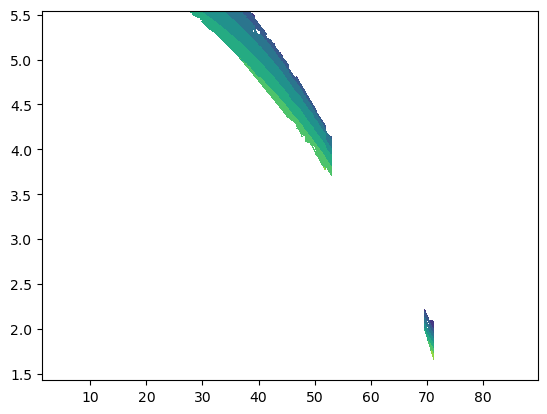

In [109]:
xi,yi = np.meshgrid(data_x, data_y)
zi = griddata((x,y),v,(xi,yi), method = 'linear')
zi
fig = plt.figure()
ax = fig.add_subplot(111)
plt.contourf(xi,yi,zi)

## Figures for SACNAS poster

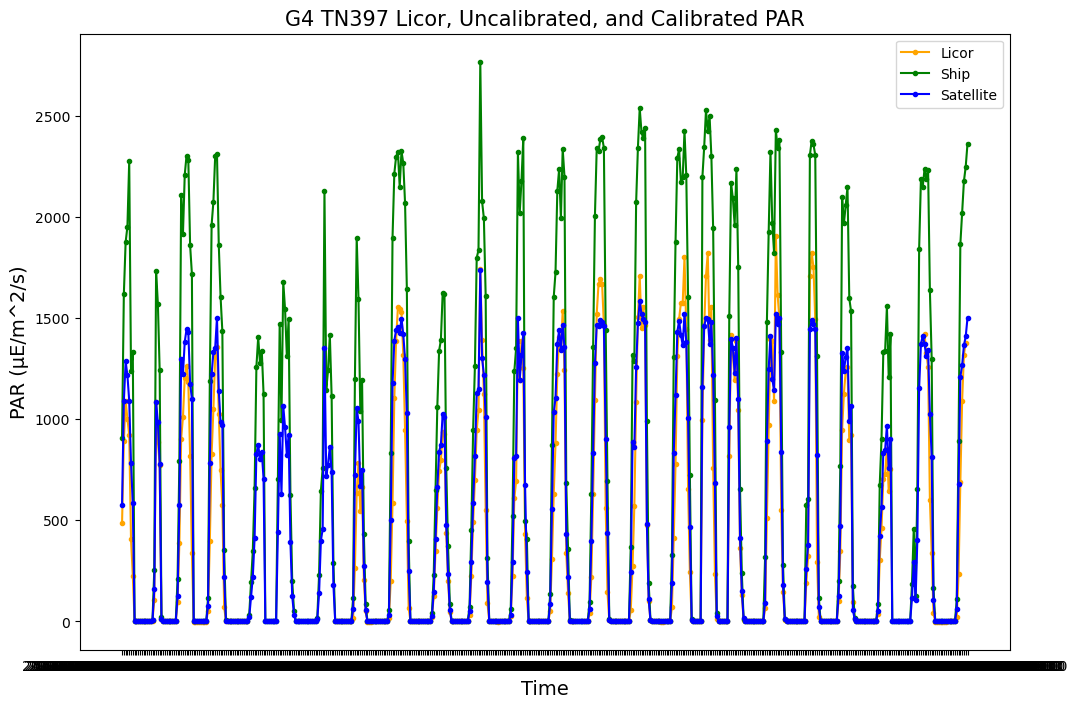

In [9]:
## attempting to make par comparison graph for G4
# setting variables
x = g4_data['time']
y = g4_data['licor_par']
y1 = g4_data['par']
y2 = g4_data['sat_par']

fig, ax = plt.subplots(sharex = True, nrows = 1, ncols = 1, figsize = (12, 8))
# plots carbon quota data
ax.plot(x, y, c='orange', marker = '.', label = 'Licor')
ax.plot(x, y1, c='green', marker = '.', label = 'Ship')
ax.plot(x, y2, c = 'blue', marker = '.', label = 'Satellite')

# makes secondary axis by sharing the the xaxis and creating yaxis
#parax = ax.twinx()
ax.set_xlabel('Time', fontsize = 14)
parax.set_ylabel('par', fontsize = 14)
ax.set_ylabel('PAR (μE/m^2/s)', fontsize = 14)
plt.title('G4 TN397 Licor, Uncalibrated, and Calibrated PAR', fontsize = 15)
ax.legend()
